In [1]:
from Funcoes import *
from tensorflow.keras.models import load_model

In [7]:
%matplotlib inline

In [8]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['lines.linewidth'] = 2

In [4]:
model_2_sps = load_model('model_sps_2.h5')
model_4_sps = load_model('model_sps_4.h5')

In [5]:
M = 16        # ordem da modulação
Fb = 24e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs = SpS*Fb    # taxa de amostragem
rolloff = 0.05  # Rolloff do filtro formatador de pulso
amostras = 512
size = 50000

def data_test_to_obtain_BERxSNR_plot(model,data,X):
    X = MinMaxScaler().fit_transform(X)
    predictions = model.predict(X)
    predicted_signal = data['amplitudes']*np.exp(1j*predictions.reshape(-1,))
    return predicted_signal.reshape((1,-1))

In [9]:
SNRs = np.arange(16,40.1,0.5)
BERs = np.zeros(SNRs.size)
SpS = 4
if SpS == 4:
    model = model_4_sps
if SpS == 2:
    model = model_2_sps
for i , SNR in enumerate(SNRs):
    qam_signal = generate_signal(M,Fb,SpS,SNR,rolloff=0.05)
    sfm, A = qam_signal_phase_min(qam_signal)
    data,X,y = dataset_02(sfm,amostras,size)
    predicted_signal = data_test_to_obtain_BERxSNR_plot(model,data,X)
    reverted_signal = revert_sfm(predicted_signal,A)
    BERs[i] = reverted_signal[0,::SpS].cal_ber()

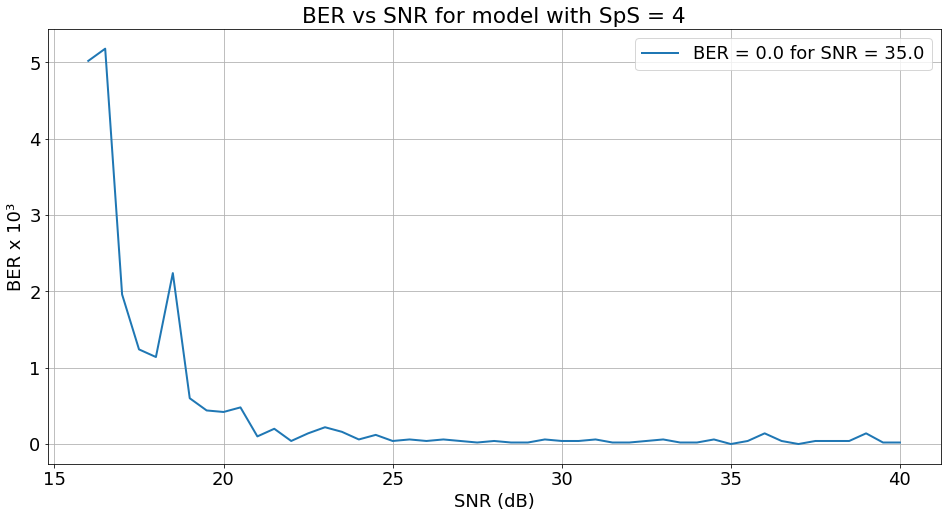

In [10]:
min_ber = np.argmin(BERs)
plt.plot(SNRs,BERs*1e3)
plt.title(f'BER vs SNR for model with SpS = {SpS}')
plt.xlabel('SNR (dB)')
plt.ylabel('BER x 10³')
plt.legend([f'BER = {BERs[min_ber]} for SNR = {SNRs[min_ber]}'])
plt.grid(True)
plt.savefig(f'BER_x_SNR_model_{SpS}_SpS.png')
np.savetxt(f'SNR_BER_model_{SpS}_sps.txt',[SNRs,BERs])

In [23]:
BERs[min_ber]

0.0003

In [26]:
SpS = 4
SNRs, BERs = np.loadtxt(f'SNR_BER_model_{SpS}_sps.txt')

In [12]:
qam_signal = generate_signal(M,Fb,SpS,30,rolloff=0.05)
sfm, A = qam_signal_phase_min(qam_signal)
data,X,y = dataset_02(sfm,amostras,size)
preds = data_test_to_obtain_BERxSNR_plot(model_2_sps,data,X)

In [13]:
preds.shape

(50000,)

In [3]:
plot = np.loadtxt('SNR_BER_model_4_sps.txt')

In [5]:
plot[0]

array([16. , 16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17. ,
       17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18. , 18.1,
       18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19. , 19.1, 19.2,
       19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3,
       20.4, 20.5, 20.6, 20.7, 20.8, 20.9, 21. , 21.1, 21.2, 21.3, 21.4,
       21.5, 21.6, 21.7, 21.8, 21.9, 22. , 22.1, 22.2, 22.3, 22.4, 22.5,
       22.6, 22.7, 22.8, 22.9, 23. , 23.1, 23.2, 23.3, 23.4, 23.5, 23.6,
       23.7, 23.8, 23.9, 24. , 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7,
       24.8, 24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7, 25.8,
       25.9, 26. , 26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9,
       27. , 27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. ,
       28.1, 28.2, 28.3, 28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1,
       29.2, 29.3, 29.4, 29.5, 29.6, 29.7, 29.8, 29.9, 30. , 30.1, 30.2,
       30.3, 30.4, 30.5, 30.6, 30.7, 30.8, 30.9, 31

<ipython-input-10-39c512dcd953>:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(plot[0],np.log10(plot[1]))


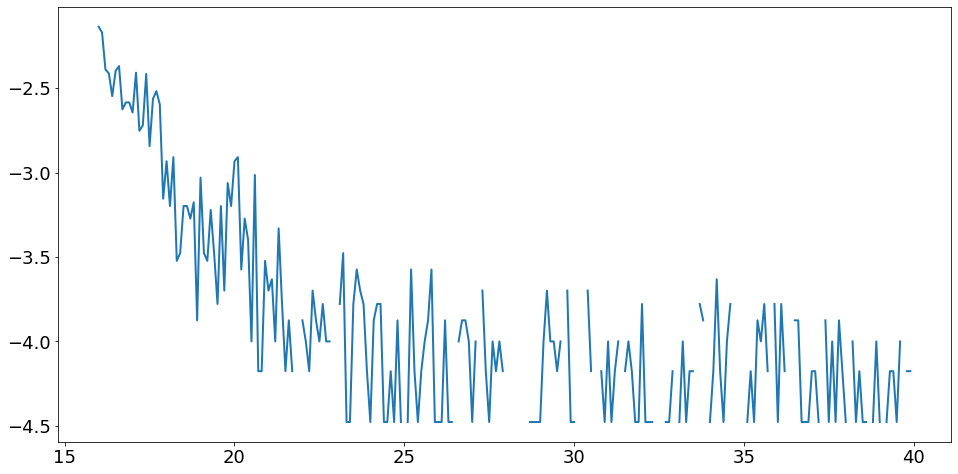

In [10]:
plt.plot(plot[0],np.log10(plot[1]))